<a href="https://colab.research.google.com/github/siva4iov/Petals-to-the-Metal.-Transfer-learning-on-Xception/blob/main/Petals_to_the_Metal_Transfer_learning_on_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Petals to the Metal - Flower Classification

Kaggle competition: [here](https://www.kaggle.com/c/tpu-getting-started)

# Step 1: Imports #

We begin by importing several Python packages.

In [ ]:
import math, re, os
import numpy as np
import tensorflow as tf

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.4


# Step 2: Distribution Strategy #

Detecting tpu, i managed to try TPU while experimenting. But for final model i fit it on gpu

In [ ]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1




# Step 3: Loading the Competition Data #

## Get GCS Path ##

Aviable only in kaggle notebook, for working in colab i manualy take it as a string

In [ ]:
PATH = ""

In [ ]:

# from kaggle_datasets import KaggleDatasets

# PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
# print(PATH)



## Load Data ##

Took from [this notebook](https://www.kaggle.com/code/ryanholbrook/create-your-first-submission)

In [ ]:

IMAGE_SIZE = [192, 192]

if not PATH:
    PATH = 'gs://kds-b3ff303edf58b5b27fca364f366efb224ebf9debd703a256f1250285/tfrecords-jpeg-192x192'
else:
    PATH = PATH + "/tfrecords-jpeg-192x192"
AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

2022-09-07 14:51:42.353526: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


## Dataset creation helper functions ##



In [ ]:

def data_augment(image, label):

    image = tf.image.random_flip_left_right(image)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() 
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):

    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))


Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


Creating datasets, and defining batch size

In [ ]:

BATCH_SIZE = 16 * strategy.num_replicas_in_sync

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

2022-09-07 14:51:44.018714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 14:51:44.119896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 14:51:44.120879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 14:51:44.123490: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Training: <PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>
Test: <PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.string)>


# Step 4: Explore Data #

Let's take a moment to look at some of the images in the dataset.

### Some helper functions.
Took from [this Notebook](https://www.kaggle.com/code/ryanholbrook/create-your-first-submission)

In [ ]:

from matplotlib import pyplot as plt

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: 
                                     
        numpy_labels = [None for _ in enumerate(numpy_images)]
  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
  
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Step 5: Define Model #

I tried several models:

Custom cnn models are too simple, but take too much time and memory to train.The limitations of the basic version of google colab prevent me from building a more complex one


Using pre-trained models shows good results, but works better if you retrain the entire architecture. What I can't do as you know

I tried to optimize RAM usage by using 192x192 pictures resolutions instead of 512x512, and removing several visualisation functions of this notebook.


So the best result I have achieved, is by using `Xception model`, pretrained on imagenet dataset. And using 192x192 resolution in fitting.



In [ ]:
EPOCHS = 12

with strategy.scope():
    pretrained_model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3],
        classes=len(CLASSES)
    )
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

83697664/83683744 [==============================] - 0s 0us/step


Unsuccessful attempt:

In [ ]:
# with strategy.scope():
#   model = tf.keras.Sequential([
#       tf.keras.layers.Input(shape=[*IMAGE_SIZE, 3],
#                             batch_size=BATCH_SIZE),

#       tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
#       tf.keras.layers.MaxPool2D(),
      
#       tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
#       tf.keras.layers.MaxPool2D(),

#       tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
#       tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
#       tf.keras.layers.MaxPool2D(),

#       tf.keras.layers.GlobalAveragePooling2D(),
#       tf.keras.layers.Dense(6, activation='relu'),
#       tf.keras.layers.Dropout(0.2),
#       tf.keras.layers.Dense(len(CLASSES), activation='softmax'),
#   ])

In [ ]:
model.compile(
    optimizer="adam",
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               213096    
Total params: 21,074,576
Trainable params: 213,096
Non-trainable params: 20,861,480
_________________________________________________________________


# Step 6: Training #

## CALLBACKS ##



### LR scheduler
We'll train this network with a special learning rate schedule.

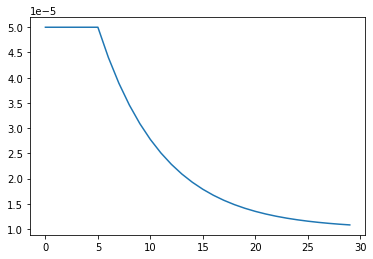

In [ ]:
LR_START = 0.00005
LR_MAX = LR_START #0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001 #LR_START
LR_RAMPUP_EPOCHS = 0 #5
LR_SUSTAIN_EPOCHS = 5 # 0
LR_EXP_DECAY = 0.85

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:  
        lr = LR_START + (epoch * (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS)   #   np.random.random_sample() * LR_START
    elif epoch < (LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS):  ####5-7lun
        lr = LR_MAX
    else:    
        lr = LR_MIN + (LR_MAX - LR_MIN) * LR_EXP_DECAY ** (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
#    print('For epoch', epoch, 'setting lr to', lr)
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(30)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)

### EarlyStop callback

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights = True)

## Fit Model ##

We're ready to train the model.

In [ ]:
import shutil # for archives with models
# Define training epochs
EPOCHS = 20
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE


loaded_model = False
# if os.path.exists("./models/xception_model") or \
#  os.path.exists("./xception_model.zip"):
#   loaded_model = True
import os
if loaded_model:
  if not os.path.exists("./models/xception_model"):
    shutil.unpack_archive("./xception_model.zip", "./models")
  model = tf.keras.models.load_model("./models/xception_model")
else:
  history = model.fit(
      ds_train,
      validation_data=ds_valid,
      epochs=EPOCHS,
      steps_per_epoch=STEPS_PER_EPOCH,
      callbacks=[early_stop, lr_callback],
  )

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 5e-05.


2022-09-07 14:51:52.501663: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-07 14:51:58.328666: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


797/797 [==============================] - 63s 62ms/step - loss: 3.7739 - sparse_categorical_accuracy: 0.1757 - val_loss: 3.2192 - val_sparse_categorical_accuracy: 0.2893
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 5e-05.
797/797 [==============================] - 33s 42ms/step - loss: 2.8880 - sparse_categorical_accuracy: 0.3615 - val_loss: 2.6434 - val_sparse_categorical_accuracy: 0.4165
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 5e-05.
797/797 [==============================] - 33s 42ms/step - loss: 2.4233 - sparse_categorical_accuracy: 0.4504 - val_loss: 2.2986 - val_sparse_categorical_accuracy: 0.4887
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 5e-05.
797/797 [==============================] - 33s 42ms/step - loss: 2.1239 - sparse_categorical_accuracy: 0.5176 - val_loss: 2.0697 - val_sparse_categorical_accuracy: 0.5383
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 5e-05.


Saving model for future use

In [ ]:
if not loaded_model:
  tf.keras.models.save_model(
      model,
      "models/xception_model",
      overwrite=True,
      include_optimizer=True,
      save_traces=True
  )

2022-09-07 15:03:45.961137: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
if not loaded_model:
  shutil.make_archive("xception_model", "zip", "./models/xception_model")

##Loss and metrics during training graph:


Fortunately, it converges

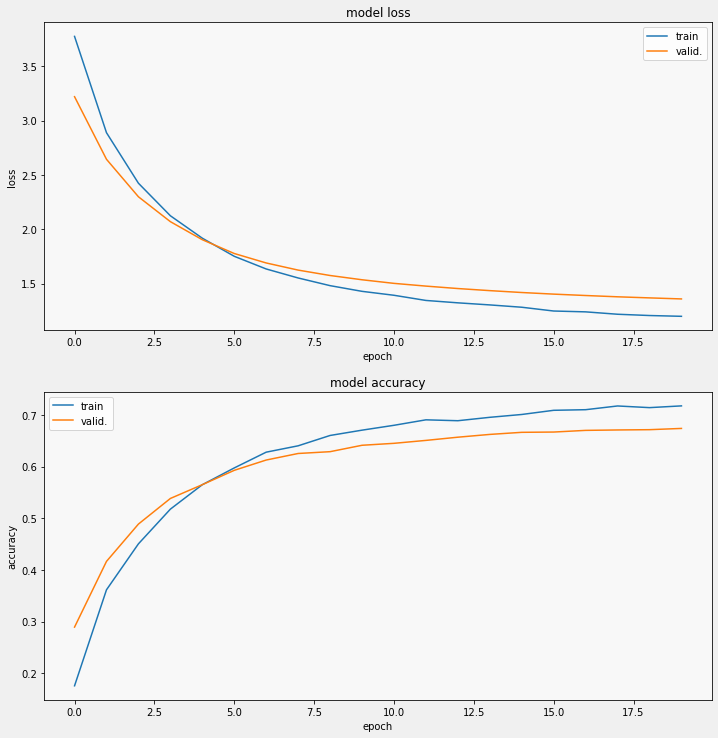

In [ ]:
if not loaded_model:
  display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
  )
  display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
  )

## Visual Validation ##
Let's visualise what we get with 0.64 accuracy on validation set

In [ ]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

And here is a set of flowers with their predicted species.

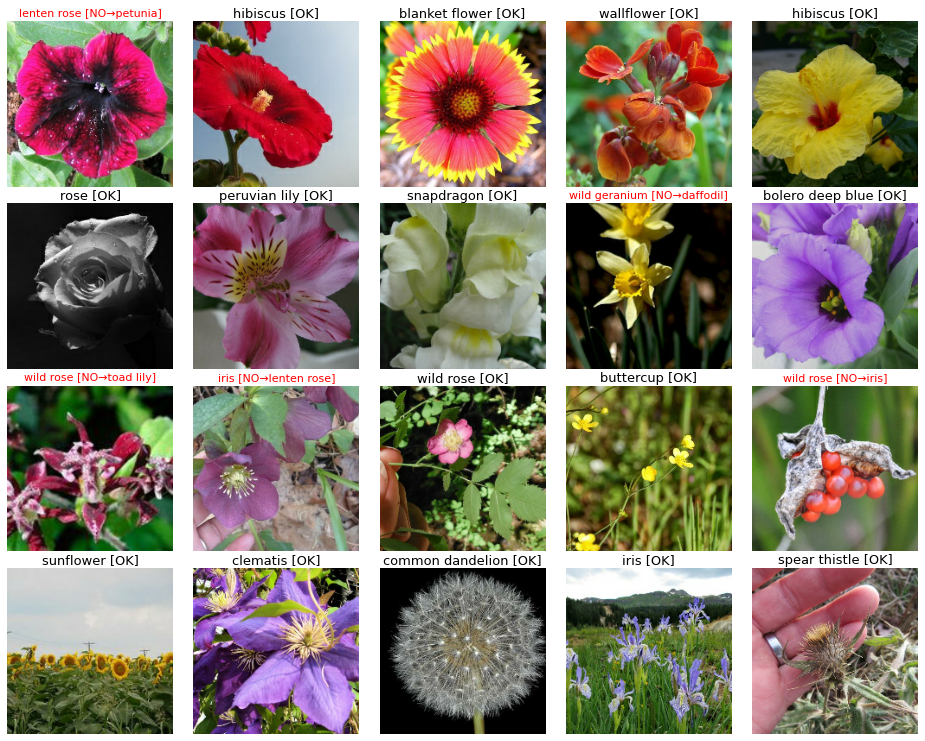

In [ ]:
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

# Step 8: Make Test Predictions #
Cells above should generate predictions for submit

In [ ]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
# print(predictions)

Computing predictions...


Generating `submissions.csv`

In [ ]:
print('Generating submission.csv file...')

test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)


Generating submission.csv file...
